# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)
- [When will each US state hit 1 case?](#us_state_0_new)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [382]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [383]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [384]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-06-09 21:23:05.890612
metric: deaths at 2020-06-09 21:23:07.622803
Latest data from 2020-06-09


In [385]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [386]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-09            Peru     203736           4040  203736      198165   
1  2020-06-09              US    1979411          18514  111989         999   
2  2020-06-09  United Kingdom     290581           1747   40968         288   
3  2020-06-09          Brazil     739503          32091   38406        1272   
4  2020-06-09           Italy     235561            283   34043          79   
5  2020-06-09          France     191523            210   29299          87   
6  2020-06-09           Spain     241966            249   27136           0   
7  2020-06-09          Mexico     124301           4199   14649         596   
8  2020-06-09         Belgium      59437             89    9619          13   
9  2020-06-09         Germany     186506            397    8736          41   
10 2020-06-09            Iran     175927           2095    8425          74   
11 2020-06-09          Canada      98241            462    7970          60   
12 2020-06-09           India     276146          10218    7750         277   
13 2020-06-09          Russia     484630           8587    6134         171   
14 2020-06-09     Netherlands      48109            164    6050          15   
15 2020-06-09          Turkey     172114            993    4729          18   
16 2020-06-09          Sweden      45924            791    4717          23   
17 2020-06-09           China      84198              3    4638           0   
18 2020-06-09         Ecuador      43917            539    3690          48   
19 2020-06-09           Chile     142759           3913    2283          19   

    mortality_rate  
0         1.000000  
1         0.056577  
2         0.140987  
3         0.051935  
4         0.144519  
5         0.152979  
6         0.112148  
7         0.117851  
8         0.161835  
9         0.046840  
10        0.047889  
11        0.081127  
12        0.028065  
13        0.012657  
14        0.125756  
15        0.027476  
16        0.102713  
17        0.055084  
18        0.084022  
19        0.015992

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [387]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date       country  confirmed  confirmed_new  deaths  deaths_new  \
3  2020-06-09        Brazil     739503          32091   38406        1272   
1  2020-06-09            US    1979411          18514  111989         999   
12 2020-06-09         India     276146          10218    7750         277   
13 2020-06-09        Russia     484630           8587    6134         171   
20 2020-06-09      Pakistan     113702           5385    2255          83   
7  2020-06-09        Mexico     124301           4199   14649         596   
0  2020-06-09          Peru     203736           4040  203736      198165   
19 2020-06-09         Chile     142759           3913    2283          19   
34 2020-06-09  Saudi Arabia     108571           3288     783          37   
31 2020-06-09    Bangladesh      71675           3171     975          45   

    mortality_rate  
3         0.051935  
1         0.056577  
12        0.028065  
13        0.012657  
20        0.019833  
7         0.117851  
0         1.000000  
19        0.015992  
34        0.007212  
31        0.013603

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [388]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

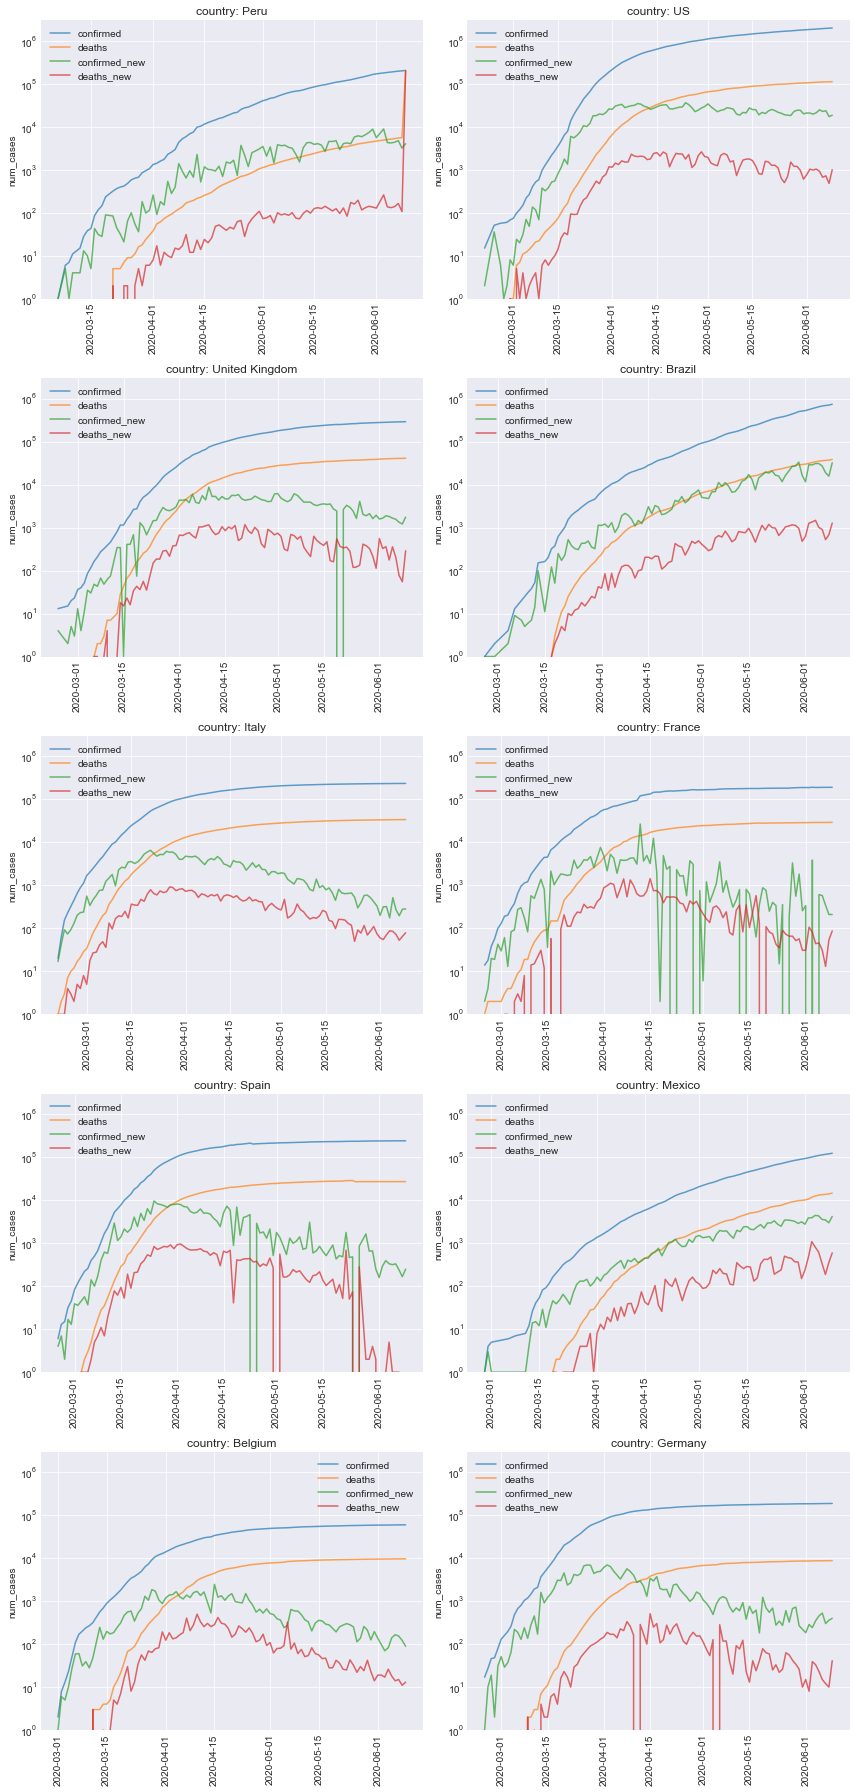

In [389]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

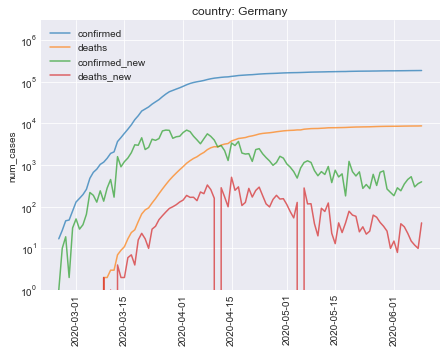

In [390]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [391]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-06-10 2020-06-16 2020-06-30  2020-06-10 2020-06-16   
country                                                                      
US                  2006149.0  2146953.0  2515135.0    112779.0   117612.0   
Peru                 208841.0   237989.0   322815.0     45299.0   526525.0   
United Kingdom       292156.0   301573.0   324743.0     41163.0    42300.0   
Brazil               771390.0   967503.0  1641353.0     39407.0    45899.0   
Italy                235886.0   237653.0   241827.0     34117.0    34552.0   
France               191253.0   191686.0   192698.0     29311.0    29561.0   
Spain                242303.0   243947.0   247824.0     27138.0    27145.0   
Mexico               129013.0   157596.0   251383.0     15203.0    18569.0   
Belgium               59598.0    60412.0    62354.0      9639.0     9733.0   
Germany              186946.0   189395.0   195235.0      8747.0     8867.0   

                            mortality_rate_pred                         \
date             2020-06-30          2020-06-10 2020-06-16  2020-06-30   
country                                                                  
US                 129711.0            0.056217   0.054781    0.051572   
Peru            161135194.0            0.216907   2.212392  499.156464   
United Kingdom      45079.0            0.140894   0.140265    0.138814   
Brazil              65512.0            0.051086   0.047441    0.039913   
Italy               35590.0            0.144633   0.145388    0.147171   
France              30154.0            0.153258   0.154216    0.156483   
Spain               27161.0            0.112000   0.111274    0.109598   
Mexico              29612.0            0.117841   0.117827    0.117796   
Belgium              9957.0            0.161734   0.161110    0.159685   
Germany              9152.0            0.046789   0.046817    0.046877   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.011370             0.007019  
Peru                          0.022014             0.505064  
United Kingdom                0.005301             0.004555  
Brazil                        0.038476             0.025740  
Italy                         0.001244             0.002115  
France                        0.000376             0.001418  
Spain                         0.001127             0.000042  
Mexico                        0.033915             0.033895  
Belgium                       0.002262             0.001628  
Germany                       0.002172             0.002265

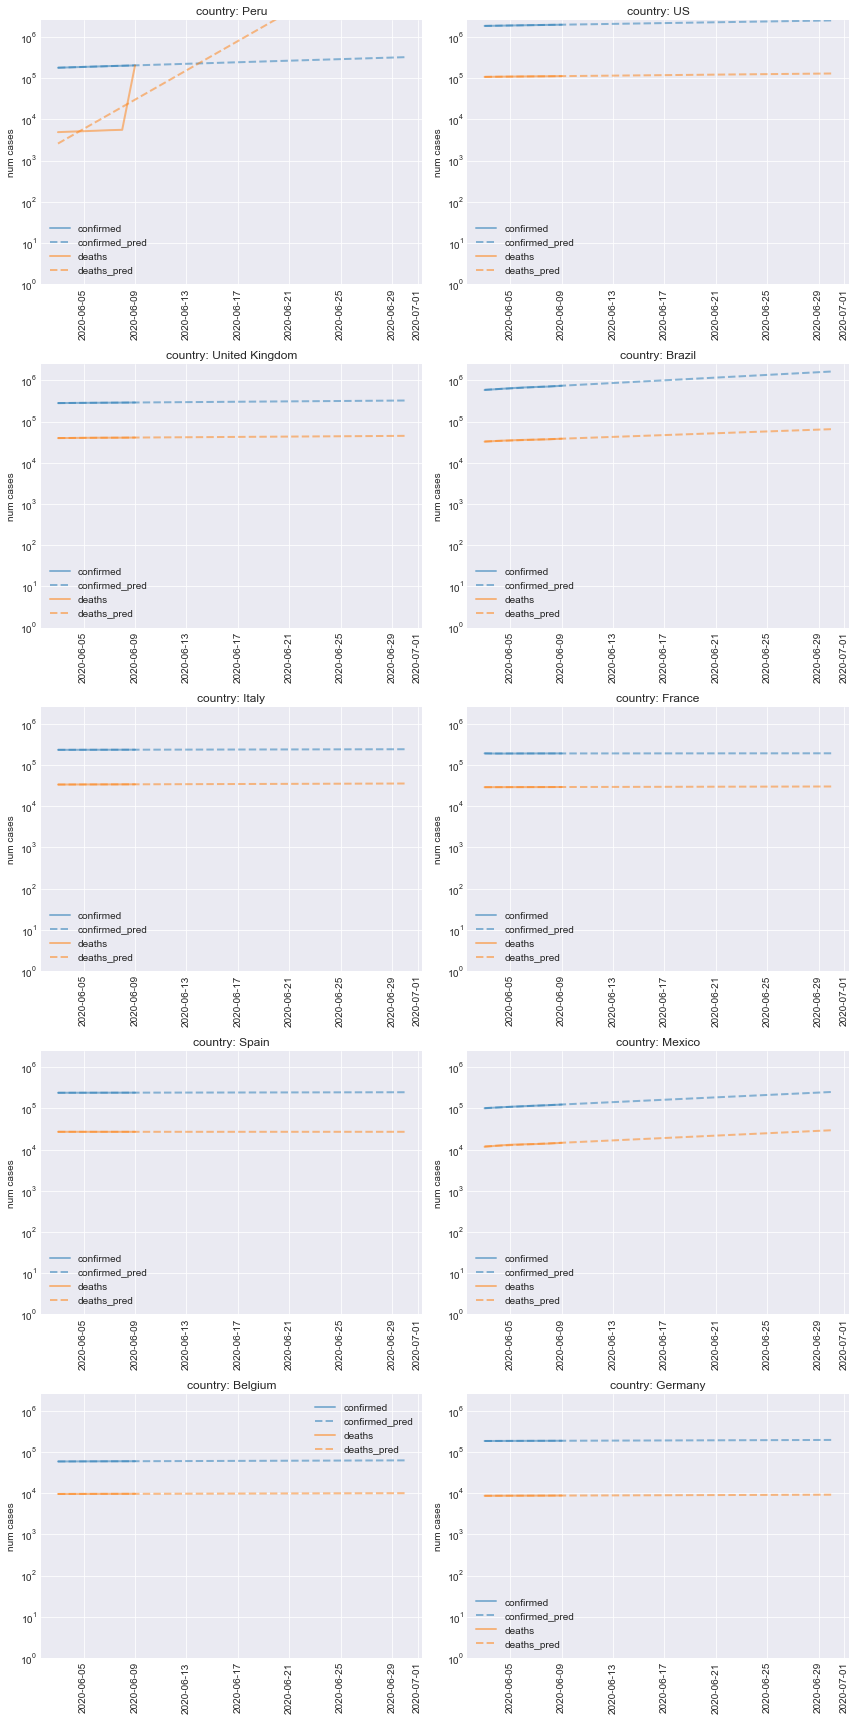

In [392]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [393]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-09_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [394]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


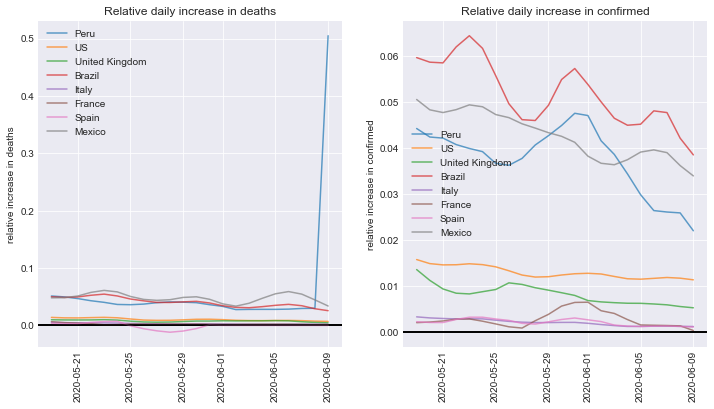

In [395]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-06-10 2020-06-16  2020-06-10 2020-06-16   
country                                                           
US                  2010196.0  2157168.0    113308.0   119052.0   
United Kingdom       292990.0   303784.0     41514.0    43259.0   
Brazil               791122.0  1032570.0     40182.0    48425.0   
Italy                236034.0   237997.0     34132.0    34588.0   
France               192970.0   196061.0     29351.0    29674.0   
Spain                242758.0   245020.0     27140.0    27149.0   
Peru                 216540.0   260280.0     16422.0    35831.0   
Mexico               130255.0   161831.0     15625.0    20222.0   
Belgium               59623.0    60442.0      9654.0     9773.0   
Germany              186789.0   188935.0      8756.0     8891.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-06-10 2020-06-16                           
country                                                                 
US                        0.056367   0.055189                0.011830   
United Kingdom            0.141691   0.142401                0.006048   
Brazil                    0.050791   0.046898                0.045392   
Italy                     0.144606   0.145330                0.001381   
France                    0.152101   0.151351                0.002652   
Spain                     0.111799   0.110803                0.001547   
Peru                      0.075838   0.137663                0.031138   
Mexico                    0.119957   0.124958                0.036838   
Belgium                   0.161917   0.161692                0.002277   
Germany                   0.046876   0.047059                0.001906   

               frac_increase_deaths  
date                                 
country                              
US                         0.008275  
United Kingdom             0.006884  
Brazil                     0.031589  
Italy                      0.002212  
France                     0.001824  
Spain                      0.000056  
Peru                       0.138863  
Mexico                     0.043914  
Belgium                    0.002034  
Germany                    0.002557

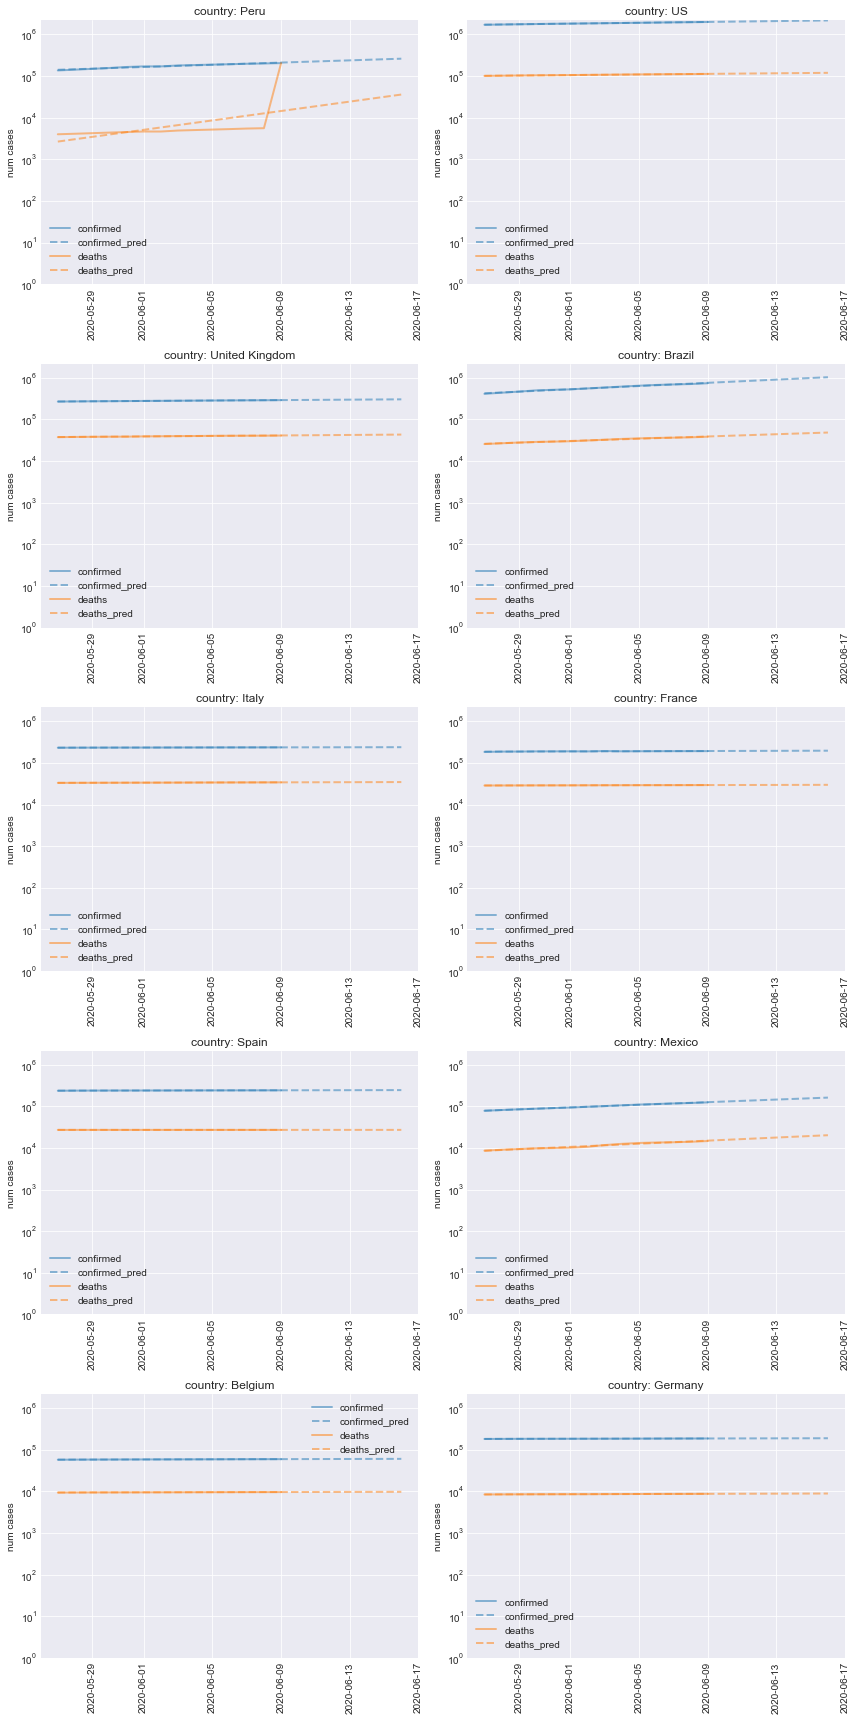

In [396]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [397]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-06-09_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [398]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

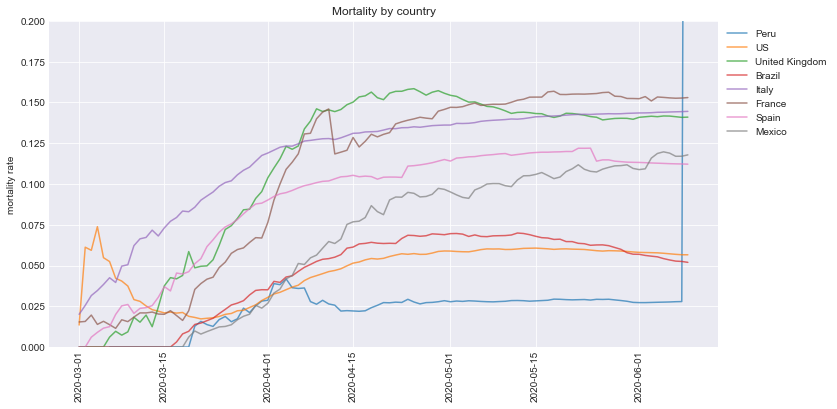

In [399]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [400]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

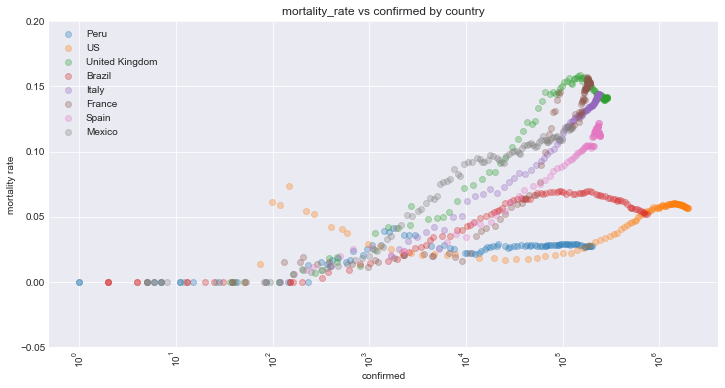

In [401]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [402]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

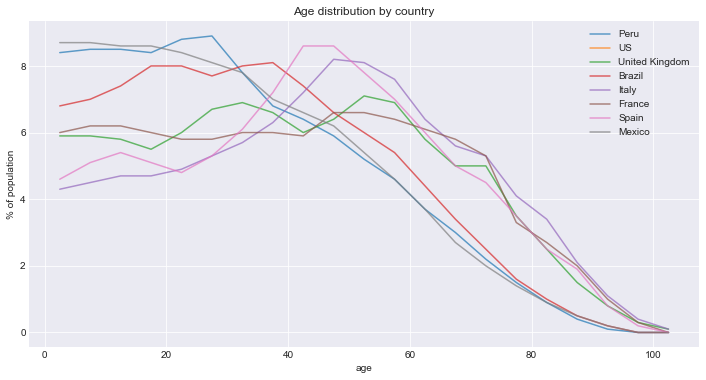

In [403]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

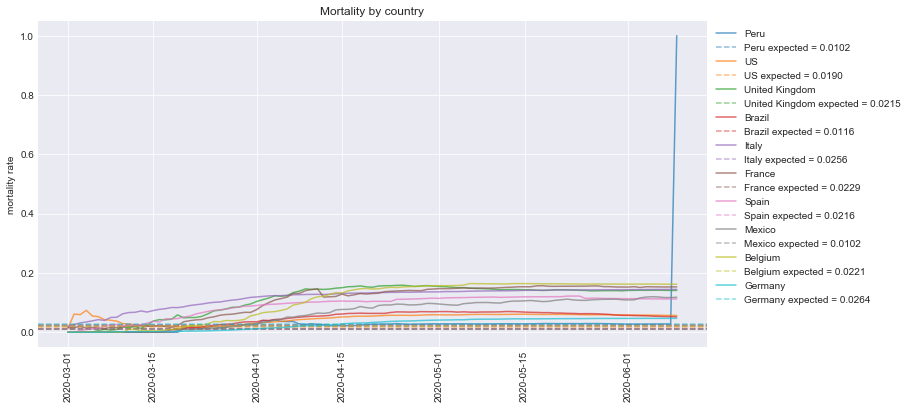

date         country  mortality_rate  confirmed    deaths
0 2020-06-09            Peru        1.000000   203736.0  203736.0
1 2020-06-09         Belgium        0.161835    59437.0    9619.0
2 2020-06-09          France        0.152979   191523.0   29299.0
3 2020-06-09           Italy        0.144519   235561.0   34043.0
4 2020-06-09  United Kingdom        0.140987   290581.0   40968.0
5 2020-06-09          Mexico        0.117851   124301.0   14649.0
6 2020-06-09           Spain        0.112148   241966.0   27136.0
7 2020-06-09              US        0.056577  1979411.0  111989.0
8 2020-06-09          Brazil        0.051935   739503.0   38406.0
9 2020-06-09         Germany        0.046840   186506.0    8736.0

In [404]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

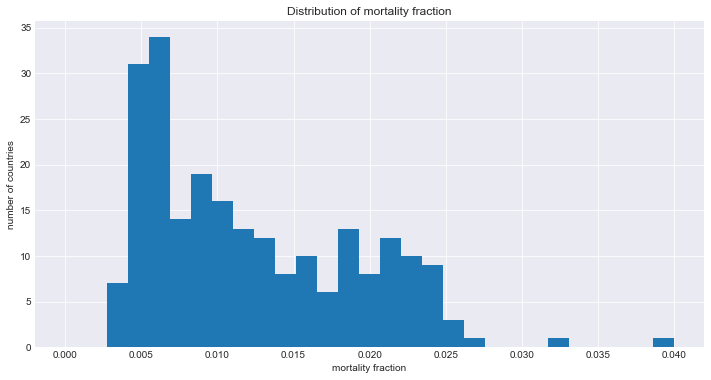

In [405]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [406]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [407]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

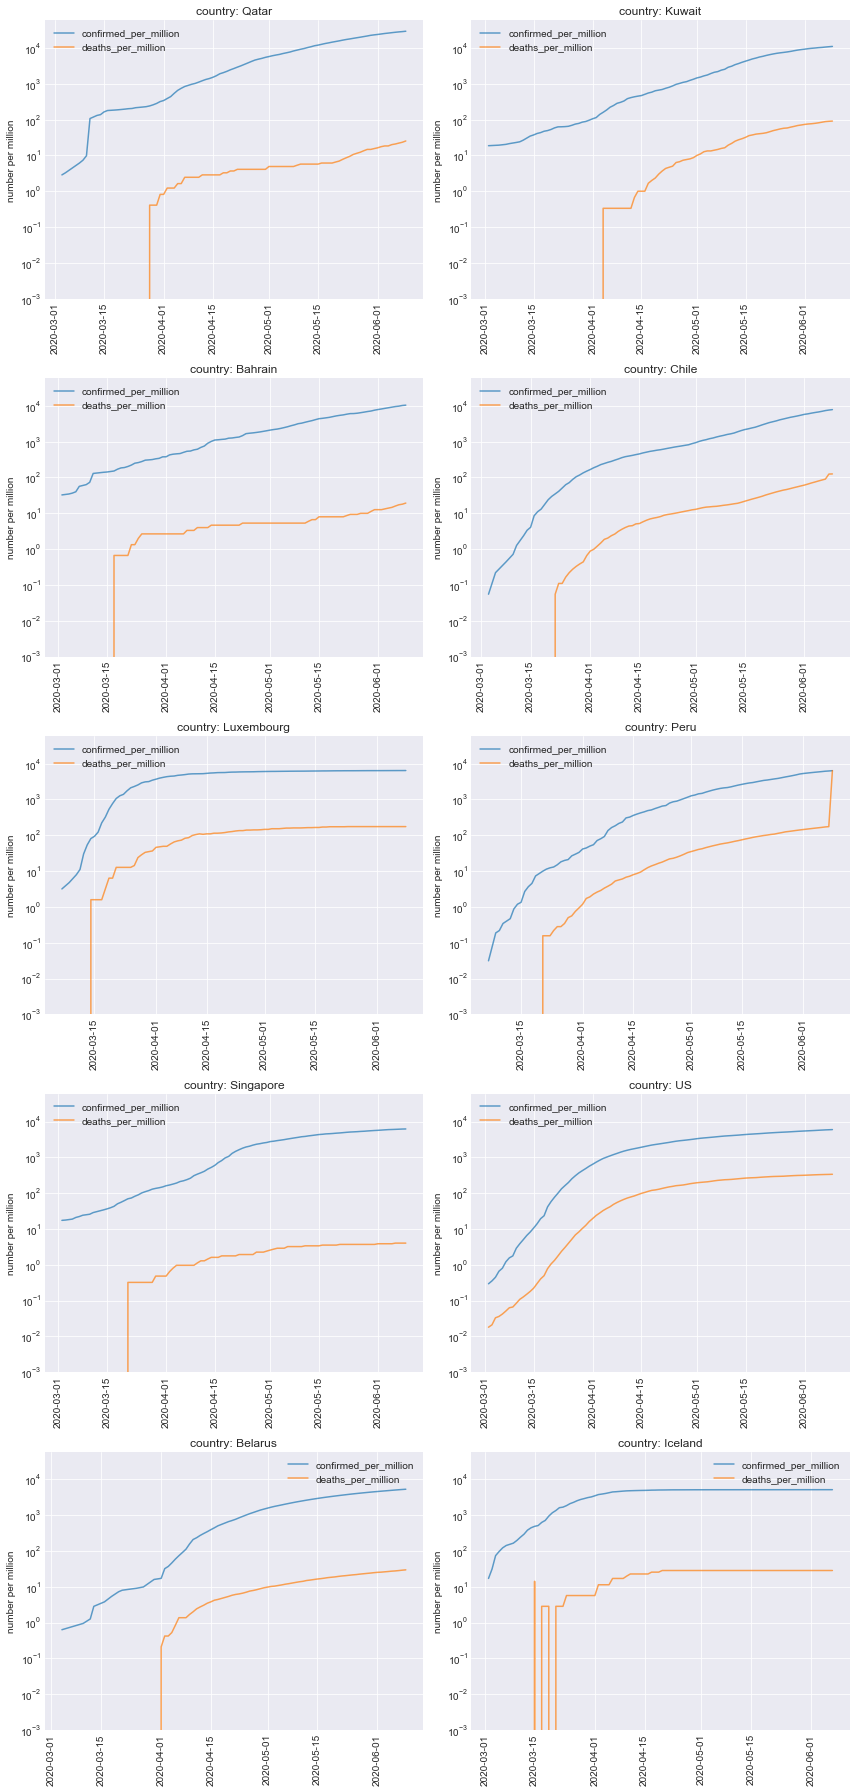

country   population  confirmed    deaths  confirmed_per_million  \
0       Qatar    2444174.0    71879.0      62.0           29408.299082   
1      Kuwait    2993706.0    33140.0     273.0           11069.891299   
2     Bahrain    1505003.0    15731.0      29.0           10452.470859   
3       Chile   18186770.0   142759.0    2283.0            7849.607159   
4  Luxembourg     628381.0     4046.0     110.0            6438.768836   
5        Peru   31914989.0   203736.0  203736.0            6383.708921   
6   Singapore    6209660.0    38514.0      25.0            6202.271944   
7          US  332639102.0  1979411.0  111989.0            5950.626334   
8     Belarus    9477918.0    50265.0     282.0            5303.379920   
9     Iceland     350734.0     1807.0      10.0            5152.052553   

   deaths_per_million  mortality_rate  
0           25.366443        0.000863  
1           91.191319        0.008238  
2           19.269065        0.001843  
3          125.530812        0.015992  
4          175.053033        0.027187  
5         6383.708921        1.000000  
6            4.025985        0.000649  
7          336.668177        0.056577  
8           29.753370        0.005610  
9           28.511636        0.005534

In [408]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [409]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed    deaths  confirmed_per_million  \
5             Peru   31914989.0   203736.0  203736.0            6383.708921   
10         Belgium   11720716.0    59437.0    9619.0            5071.106577   
19  United Kingdom   65761117.0   290581.0   40968.0            4418.735771   
21           Italy   62402659.0   235561.0   34043.0            3774.855171   
14           Spain   50015792.0   241966.0   27136.0            4837.792032   
17          Sweden   10202491.0    45924.0    4717.0            4501.253664   
28          France   67848156.0   191523.0   29299.0            2822.818059   
29     Netherlands   17280397.0    48109.0    6050.0            2784.021687   
7               US  332639102.0  1979411.0  111989.0            5950.626334   
13         Ireland    5176569.0    25215.0    1691.0            4870.986941   

    deaths_per_million  mortality_rate  
5          6383.708921        1.000000  
10          820.683651        0.161835  
19          622.982119        0.140987  
21          545.537651        0.144519  
14          542.548641        0.112148  
17          462.338070        0.102713  
28          431.831928        0.152979  
29          350.107697        0.125756  
7           336.668177        0.056577  
13          326.664244        0.067063

### Mortality rate by deaths per capita, confirmed per capita

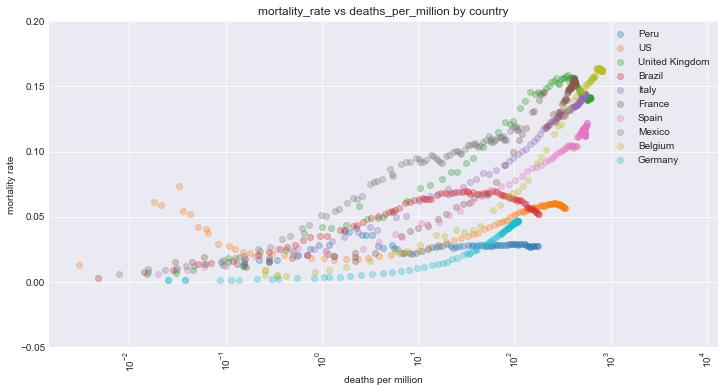

In [410]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

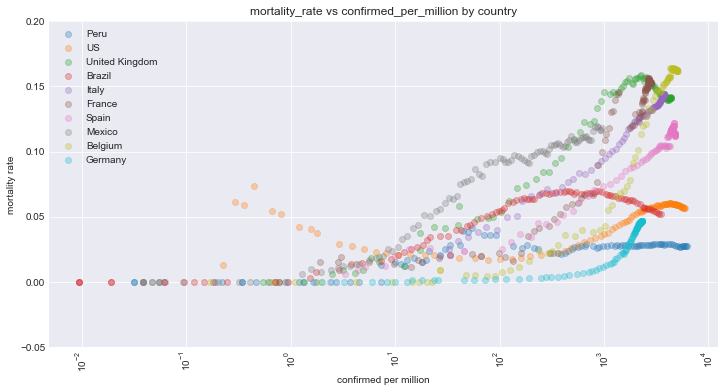

In [411]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [412]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

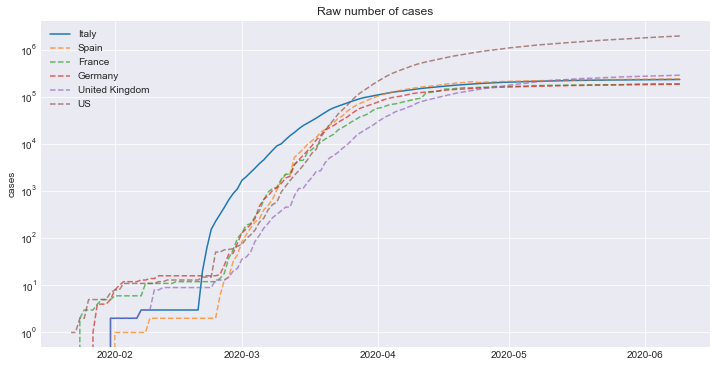

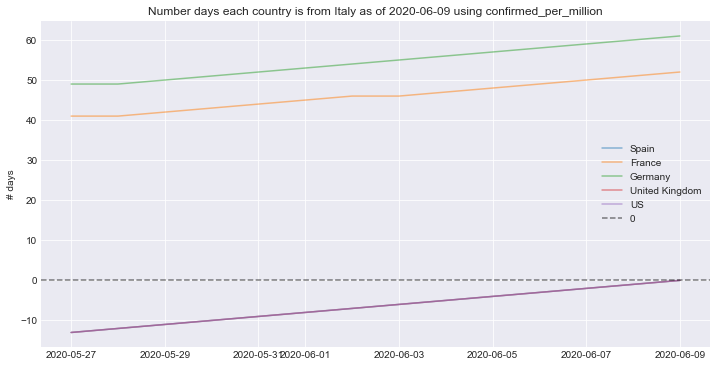

In [413]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

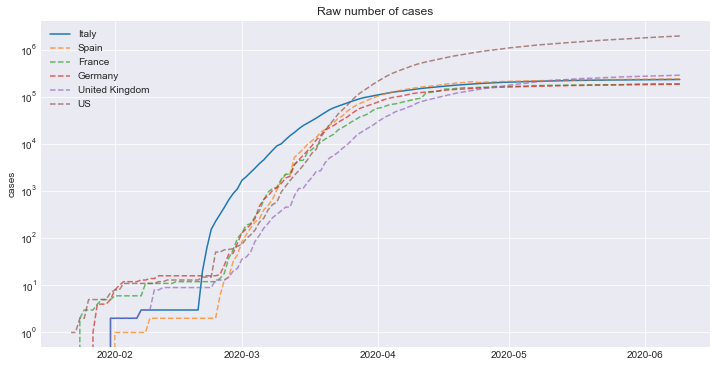

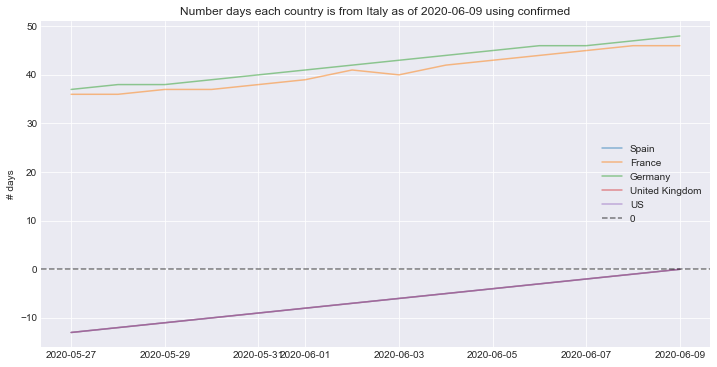

In [414]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [415]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [416]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [417]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [418]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [419]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-06-10       New York     379482            683   30458          41   
1  2020-06-10     New Jersey     164796            299   12303          89   
2  2020-06-10  Massachusetts     103889            263    7408          55   
3  2020-06-10       Illinois     129212            797    6018          94   
4  2020-06-10   Pennsylvania      80870            531    6014          61   
5  2020-06-10       Michigan      64998            585    5943          48   
6  2020-06-10     California     136641           2825    4745          88   
7  2020-06-10    Connecticut      44179             87    4097          13   
8  2020-06-10      Louisiana      43612            562    2957          13   
9  2020-06-10       Maryland      58904            500    2811          35   
10 2020-06-10        Florida      66000           1096    2765          53   
11 2020-06-10           Ohio      39162            325    2423          17   
12 2020-06-10        Indiana      38033            410    2339          23   
13 2020-06-10        Georgia      53249            752    2285          77   
14 2020-06-10          Texas      78130           1667    1867          19   

    mortality_rate  
0         0.080262  
1         0.074656  
2         0.071307  
3         0.046575  
4         0.074366  
5         0.091434  
6         0.034726  
7         0.092736  
8         0.067802  
9         0.047722  
10        0.041894  
11        0.061871  
12        0.061499  
13        0.042912  
14        0.023896

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [420]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

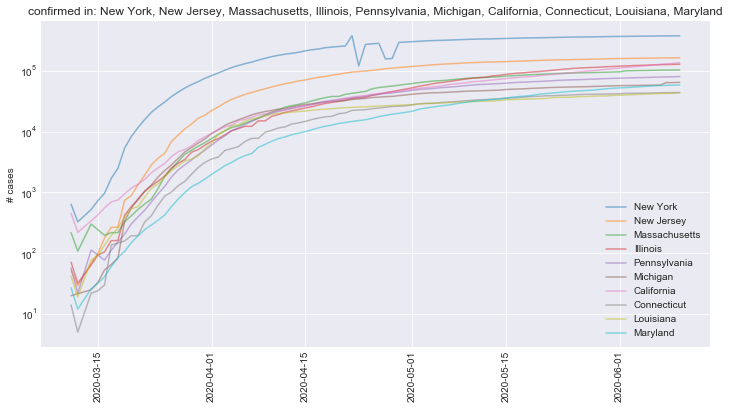

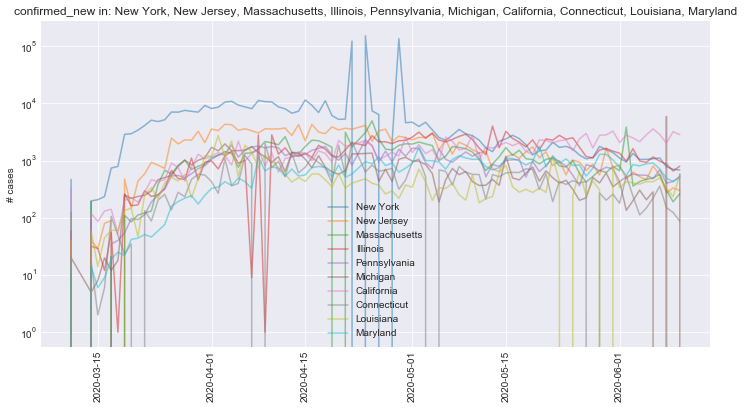

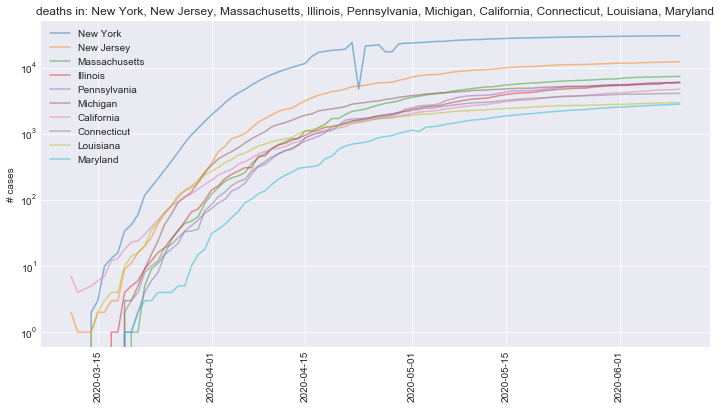

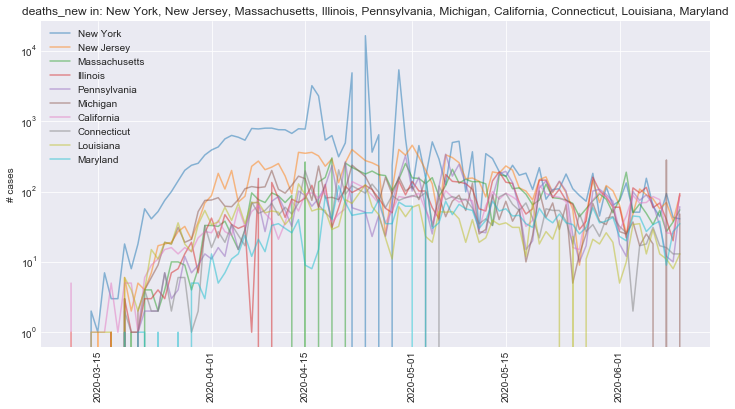

In [421]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

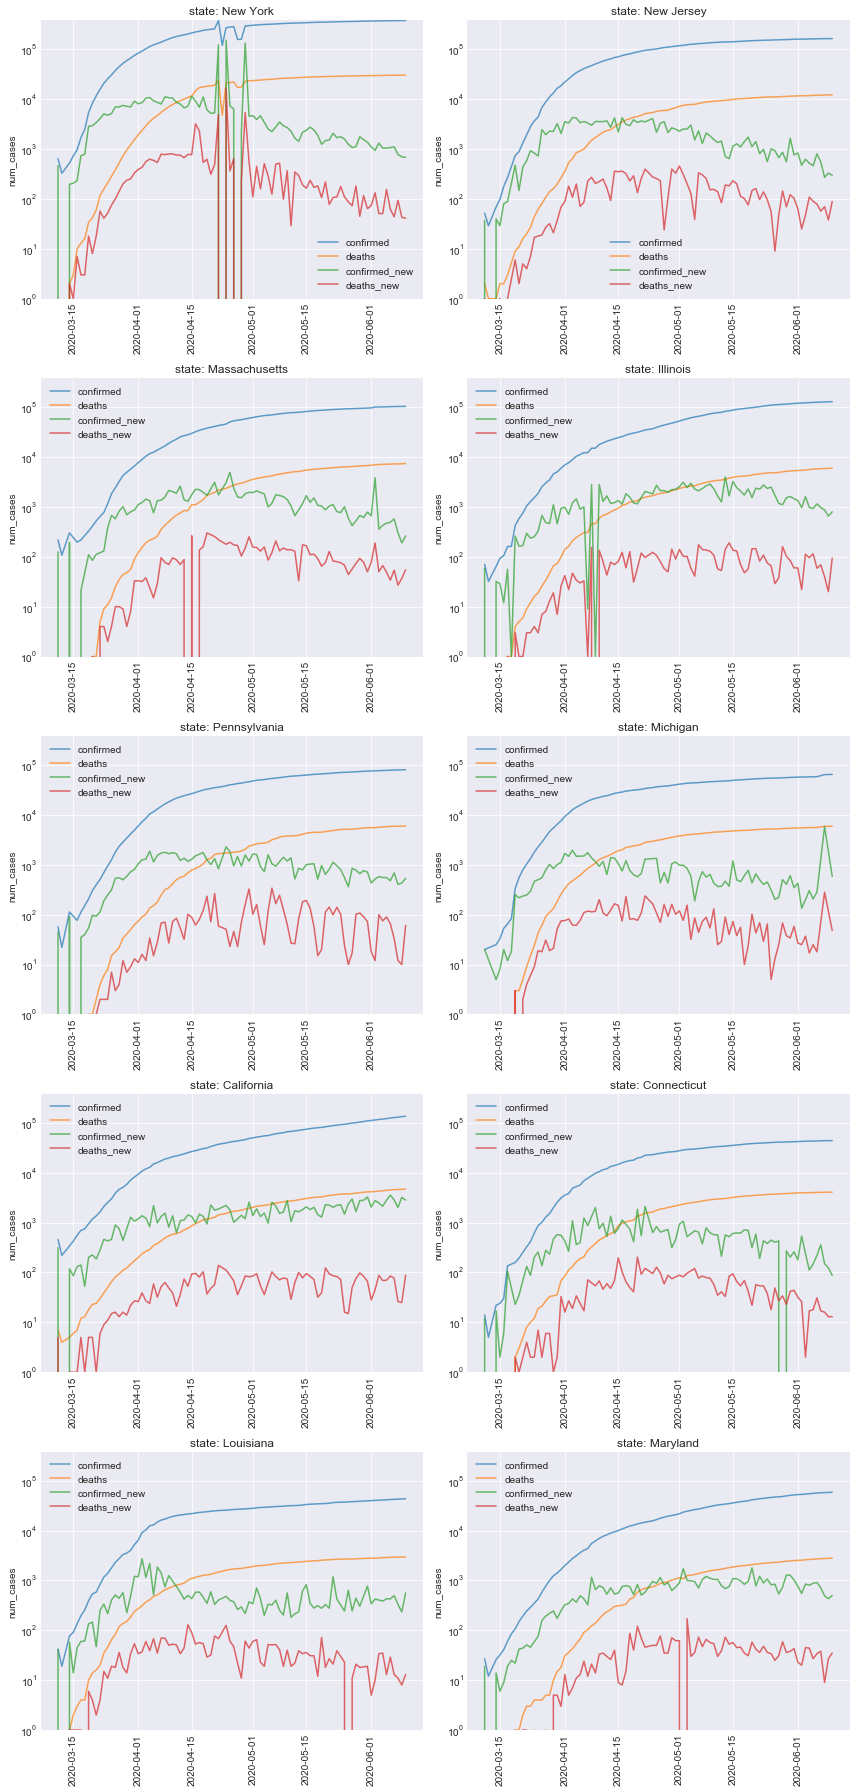

In [422]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

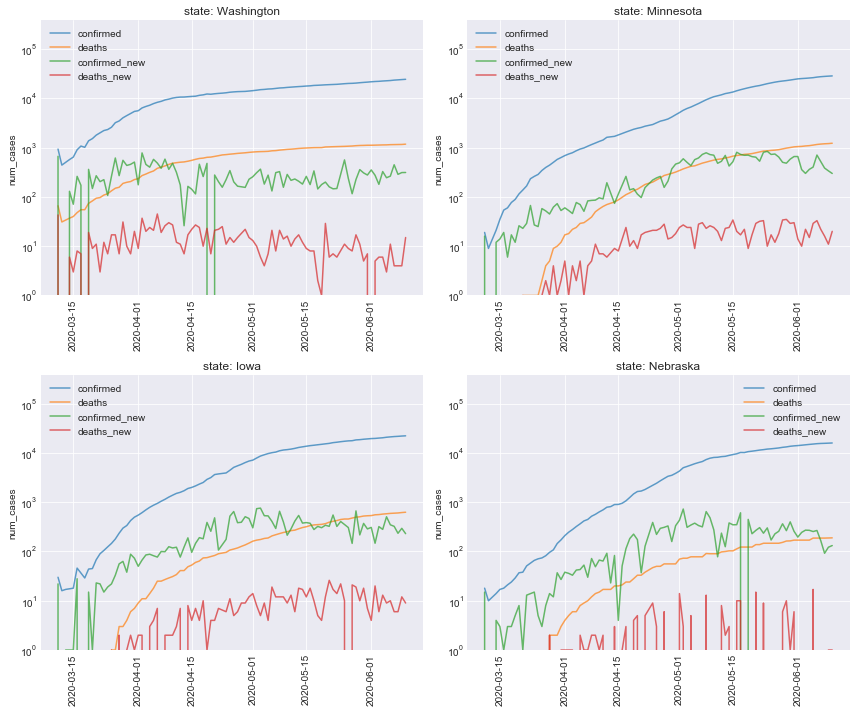

In [423]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-06-11 2020-06-17 2020-07-01  2020-06-11 2020-06-17   
state                                                                       
New York            380662.0   386202.0   399445.0     30558.0    30981.0   
New Jersey          165470.0   168302.0   175100.0     12371.0    12791.0   
Massachusetts       104466.0   106866.0   112683.0      7445.0     7702.0   
Illinois            130339.0   136044.0   150346.0      6081.0     6468.0   
Pennsylvania         81438.0    84662.0    92689.0      6061.0     6310.0   
Michigan             66750.0    76517.0   105229.0      6021.0     6488.0   
California          139980.0   160079.0   218926.0      4809.0     5195.0   
Connecticut          44480.0    45693.0    48652.0      4122.0     4235.0   
Louisiana            44008.0    46583.0    53194.0      2976.0     3067.0   
Maryland             59828.0    64031.0    75022.0      2838.0     3016.0   

                         mortality_rate_pred                        \
date          2020-07-01          2020-06-11 2020-06-17 2020-07-01   
state                                                                
New York         31990.0            0.080276   0.080220   0.080086   
New Jersey       13827.0            0.074763   0.076000   0.078966   
Massachusetts     8337.0            0.071267   0.072072   0.073986   
Illinois          7469.0            0.046655   0.047543   0.049679   
Pennsylvania      6930.0            0.074425   0.074532   0.074766   
Michigan          7720.0            0.090202   0.084792   0.073364   
California        6221.0            0.034355   0.032453   0.028416   
Connecticut       4511.0            0.092671   0.092684   0.092720   
Louisiana         3289.0            0.067624   0.065839   0.061830   
Maryland          3476.0            0.047436   0.047102   0.046333   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.002411             0.002294  
New Jersey                   0.002832             0.005580  
Massachusetts                0.003793             0.005674  
Illinois                     0.007166             0.010334  
Pennsylvania                 0.006491             0.006720  
Michigan                     0.023020             0.012504  
California                   0.022614             0.012953  
Connecticut                  0.004492             0.004523  
Louisiana                    0.009524             0.005001  
Maryland                     0.011379             0.010186

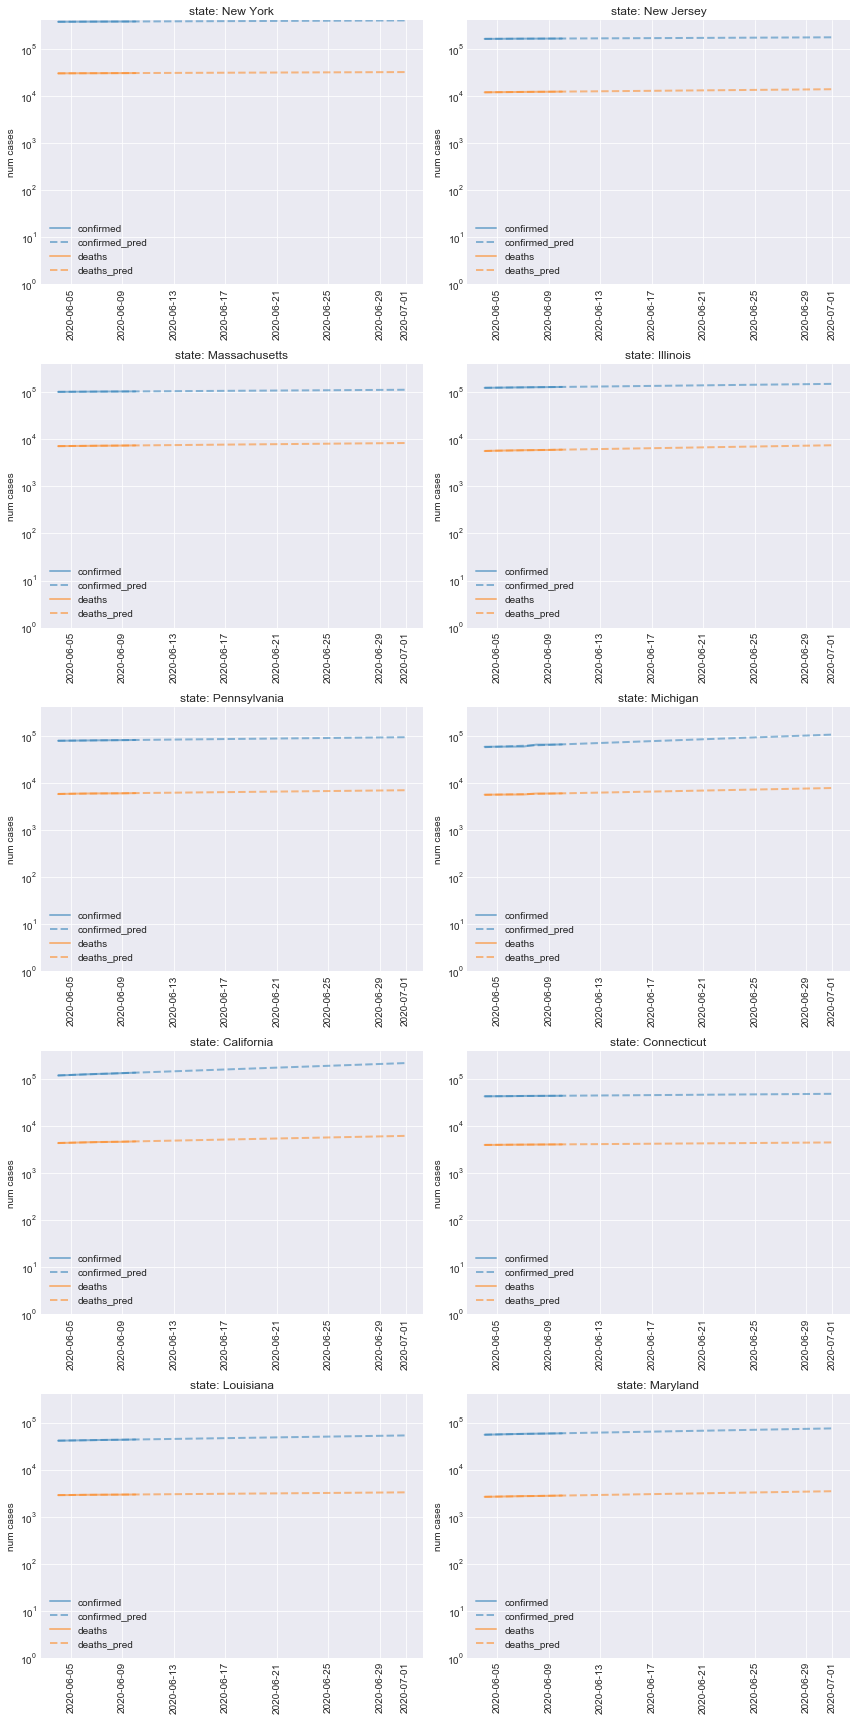

In [424]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-06-11 2020-06-17 2020-07-01  2020-06-11 2020-06-17   
state                                                                       
New York            381510.0   388344.0   404770.0     30598.0    31087.0   
New Jersey          166207.0   170122.0   179618.0     12398.0    12864.0   
Massachusetts       106335.0   111736.0   125429.0      7562.0     8011.0   
Illinois            131522.0   139127.0   158624.0      6136.0     6633.0   
Pennsylvania         81676.0    85270.0    94283.0      6133.0     6512.0   
Michigan             63964.0    68372.0    79875.0      5923.0     6207.0   
California          140398.0   161096.0   222048.0      4842.0     5292.0   
Connecticut          44657.0    46137.0    49782.0      4143.0     4284.0   
Louisiana            44069.0    46763.0    53706.0      2993.0     3115.0   
Maryland             60652.0    66250.0    81402.0      2862.0     3083.0   

                         mortality_rate_pred                        \
date          2020-07-01          2020-06-11 2020-06-17 2020-07-01   
state                                                                
New York         32259.0            0.080202   0.080050   0.079697   
New Jersey       14021.0            0.074594   0.075616   0.078060   
Massachusetts     9164.0            0.071115   0.071696   0.073061   
Illinois          7955.0            0.046654   0.047676   0.050150   
Pennsylvania      7490.0            0.075089   0.076369   0.079442   
Michigan          6924.0            0.092599   0.090783   0.086685   
California        6510.0            0.034488   0.032850   0.029318   
Connecticut       4634.0            0.092774   0.092854   0.093086   
Louisiana         3421.0            0.067916   0.066612   0.063699   
Maryland          3668.0            0.047187   0.046536   0.045060   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.002964             0.002646  
New Jersey                   0.003887             0.006170  
Massachusetts                0.008291             0.009652  
Illinois                     0.009412             0.013059  
Pennsylvania                 0.007203             0.010042  
Michigan                     0.011169             0.007834  
California                   0.023185             0.014902  
Connecticut                  0.005446             0.005614  
Louisiana                    0.009937             0.006710  
Maryland                     0.014821             0.012475

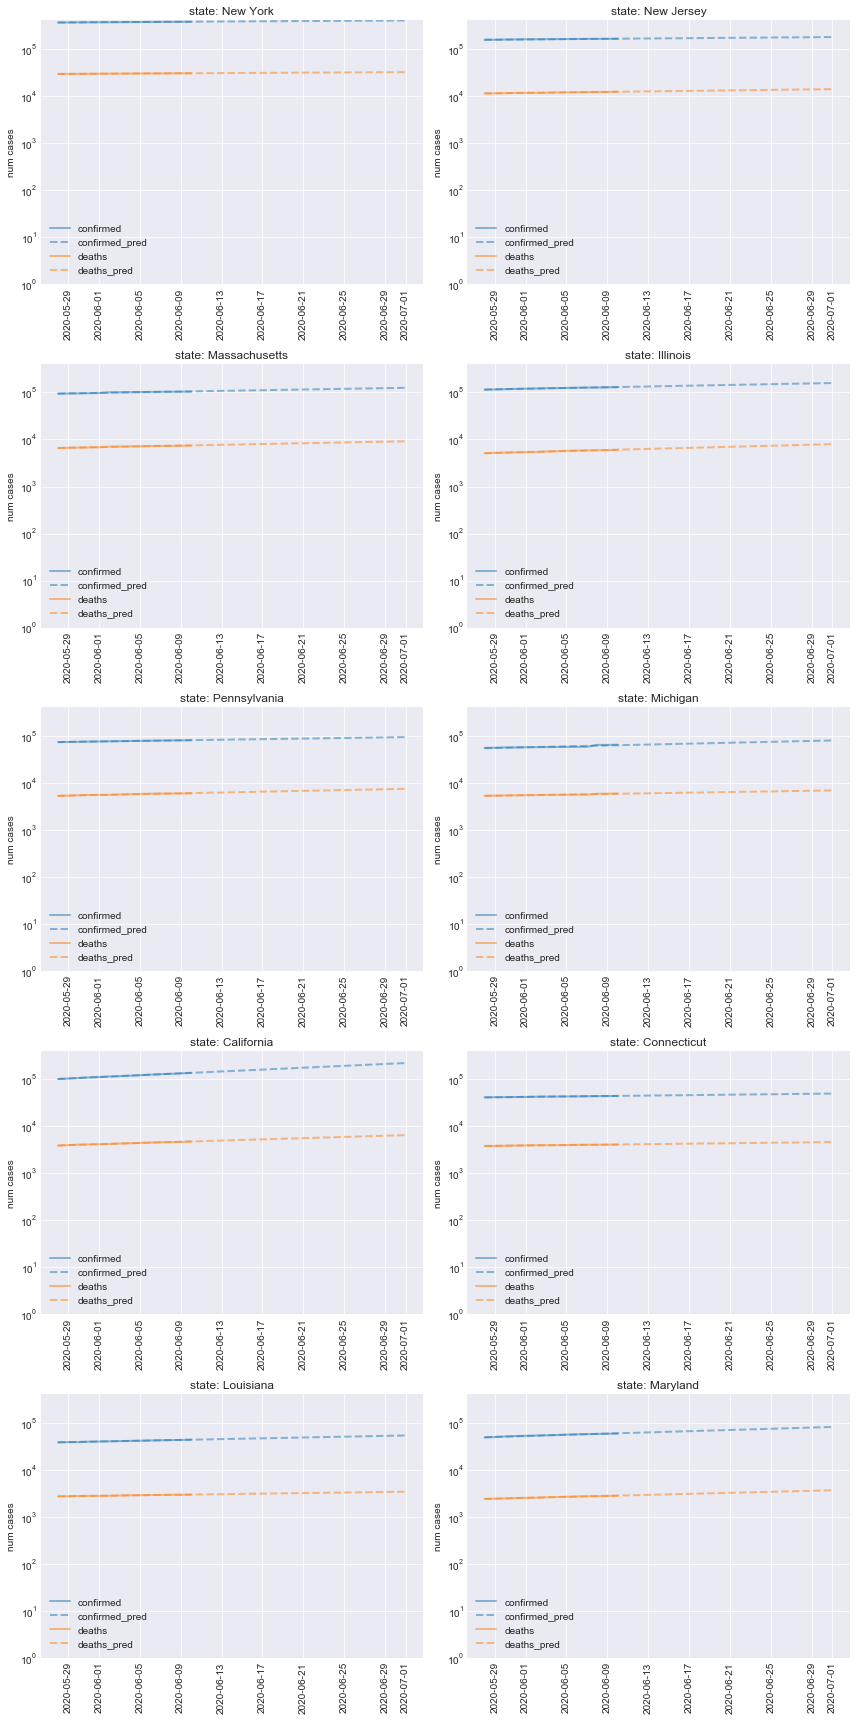

In [425]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [426]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [427]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-06-10        South Carolina      15228     568          11   
1  2020-06-10               Alabama      21422     729          11   
2  2020-06-10             Minnesota      28523    1228          20   
3  2020-06-10             Tennessee      27575     435          14   
4  2020-06-10          North Dakota       2901      72           0   
5  2020-06-10              Arkansas      10080     161           6   
6  2020-06-10               Arizona      28296    1076          23   
7  2020-06-10                  Iowa      22237     626           9   
8  2020-06-10          Rhode Island      15691     808           9   
9  2020-06-10            California     136641    4745          88   
10 2020-06-10                  Utah      12559     127           3   
11 2020-06-10              Delaware      10020     410          12   
12 2020-06-10              Michigan      64998    5943          48   
13 2020-06-10           Mississippi      18123     847          10   
14 2020-06-10         New Hampshire       5079     286           0   
15 2020-06-10         West Virginia       2169      84           0   
16 2020-06-10          South Dakota       5523      68           3   
17 2020-06-10              Nebraska      15918     189           1   
18 2020-06-10            New Mexico       9105     404           4   
19 2020-06-10               Florida      66000    2765          53   
20 2020-06-10                 Texas      78130    1867          19   
21 2020-06-10             Wisconsin      21308     661          15   
22 2020-06-10              Missouri      15352     845          22   
23 2020-06-10                Alaska        572      11           1   
24 2020-06-10               Georgia      53249    2285          77   
25 2020-06-10               Indiana      38033    2339          23   
26 2020-06-10        North Carolina      37227    1068          27   
27 2020-06-10               Montana        554      18           0   
28 2020-06-10              Illinois     129212    6018          94   
29 2020-06-10              Maryland      58904    2811          35   
30 2020-06-10              Kentucky      11707     477           5   
31 2020-06-10                Oregon       4988     169           5   
32 2020-06-10                 Maine       2606     100           1   
33 2020-06-10  District of Columbia       9474     495           4   
34 2020-06-10                  Ohio      39162    2423          17   
35 2020-06-10                Kansas      10609     237           1   
36 2020-06-10              Virginia      51738    1496          19   
37 2020-06-10          Pennsylvania      80870    6014          61   
38 2020-06-10         Massachusetts     103889    7408          55   
39 2020-06-10                Nevada      10045     446           4   
40 2020-06-10            New Jersey     164796   12303          89   
41 2020-06-10              Colorado      28333    1553          10   
42 2020-06-10             Louisiana      43612    2957          13   
43 2020-06-10              Oklahoma       7363     354           6   
44 2020-06-10           Connecticut      44179    4097          13   
45 2020-06-10            Washington      24354    1176          15   
46 2020-06-10                 Idaho       3221      85           2   
47 2020-06-10           Puerto Rico       5185     142           0   
48 2020-06-10              New York     379482   30458          41   
49 2020-06-10                  Guam        180       5           0   
50 2020-06-10                Hawaii        682      17           0   
51 2020-06-10        Virgin Islands         71       6           0   
52 2020-06-10               Vermont       1084      55           0   
53 2020-06-10        Grand Princess        103       3           0   
54 2020-06-10               Wyoming        970      17           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.037         

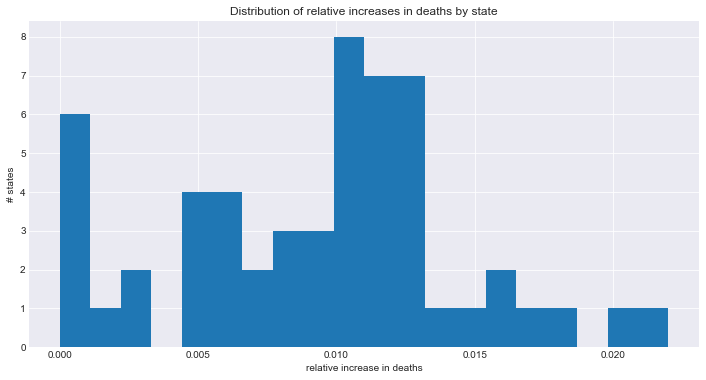

In [428]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

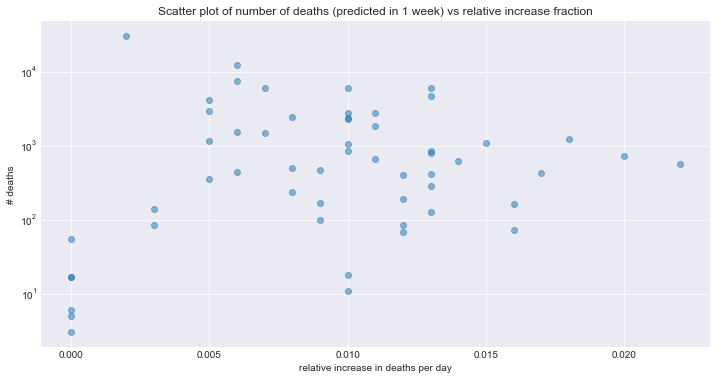

In [429]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [430]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

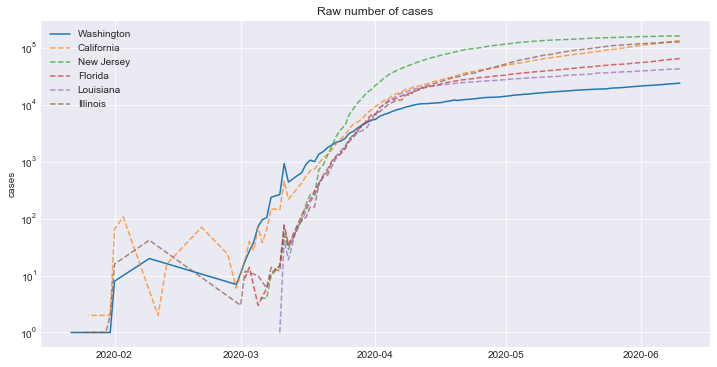

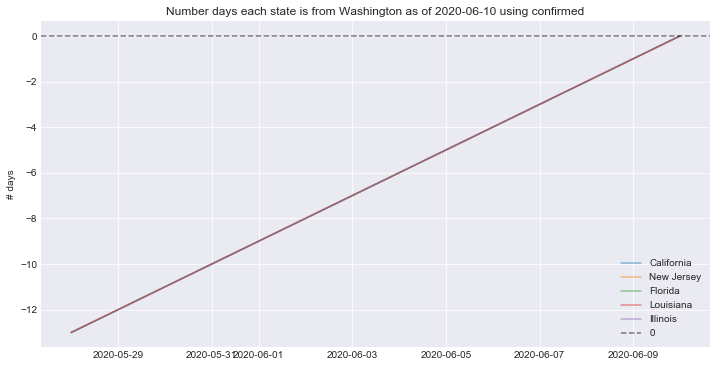

In [431]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

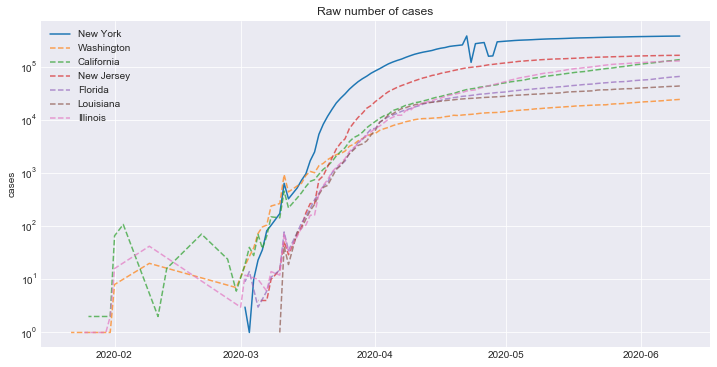

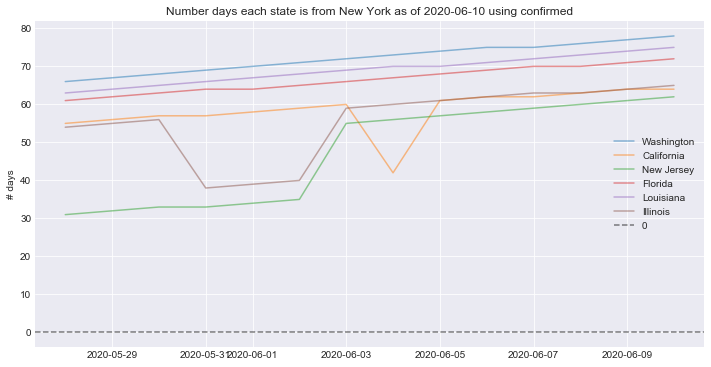

In [432]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

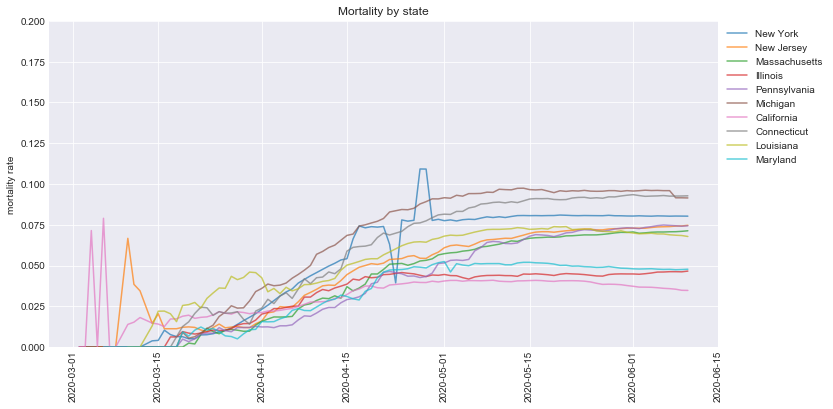

In [433]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

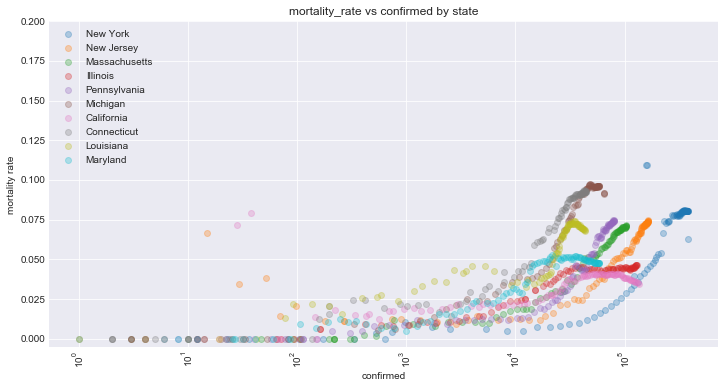

In [434]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

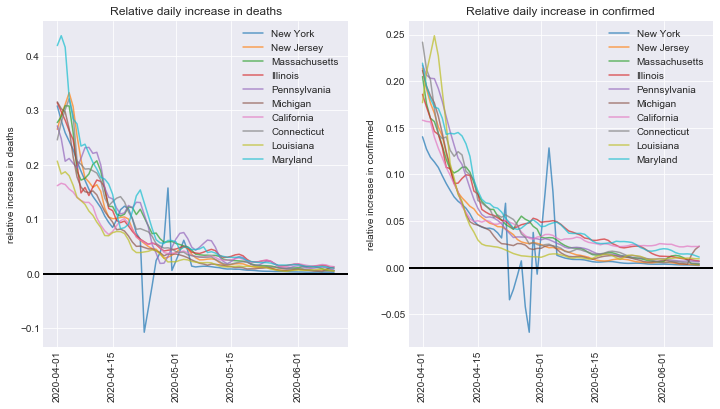

In [435]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [436]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [437]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-06-11 2020-06-17 2020-06-24 2020-07-08   
state                                                                      
California                         2969       3373       3914       5271   
New York                            956        782        620        388   
Illinois                            944        712        512        265   
Maryland                            727        645        560        423   
Massachusetts                       649        565        481        348   
New Jersey                          508        388        282        150   
Pennsylvania                        496        418        342        229   
Michigan                            472        482        494        518   
Louisiana                           391        389        387        383   
Connecticut                         174        126         87         41   

                                                                      \
date          2020-08-05 2020-09-02 2020-09-30 2020-10-28 2020-11-25   
state                                                                  
California          9561      17340      31450      57040     103452   
New York             152         60         23          9          3   
Illinois              71         19          5          1          0   
Maryland             241        137         78         44         25   
Massachusetts        182         95         50         26         13   
New Jersey            42         12          3          0          0   
Pennsylvania         103         46         21          9          4   
Michigan             569        626        688        757        832   
Louisiana            375        367        359        352        344   
Connecticut            9          2          0          0          0   

                         deaths_new_smooth_pred                        \
date          2021-01-20             2020-06-11 2020-06-17 2020-06-24   
state                                                                   
California        340297                     60         58         55   
New York               0                     67         53         40   
Illinois               0                     68         62         55   
Maryland               8                     30         28         25   
Massachusetts          3                     58         51         43   
New Jersey             0                     61         51         40   
Pennsylvania           0                     50         42         35   
Michigan            1006                     36         34         32   
Louisiana            330                     16         14         12   
Connecticut            0                     17         12          8   

                                                                      \
date          2020-07-08 2020-08-05 2020-09-02 2020-09-30 2020-10-28   
state                                                                  
California            49         40         32         26         21   
New York              23          7          2          0          0   
Illinois              44         28         18         11          7   
Maryland              20         12          8          5          3   
Massachusetts         31         16          8          4          2   
New Jersey            26         10          4          1          0   
Pennsylvania          23         10          4          2          1   
Michigan              28         22         17         13         10   
Louisiana              9          5          3          1          0   
Connecticut            3          0          0          0          0   

                                    frac_increase_confirmed  \
date          2020-11-25 2021-01-20                           
state                                                         
California  

In [438]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

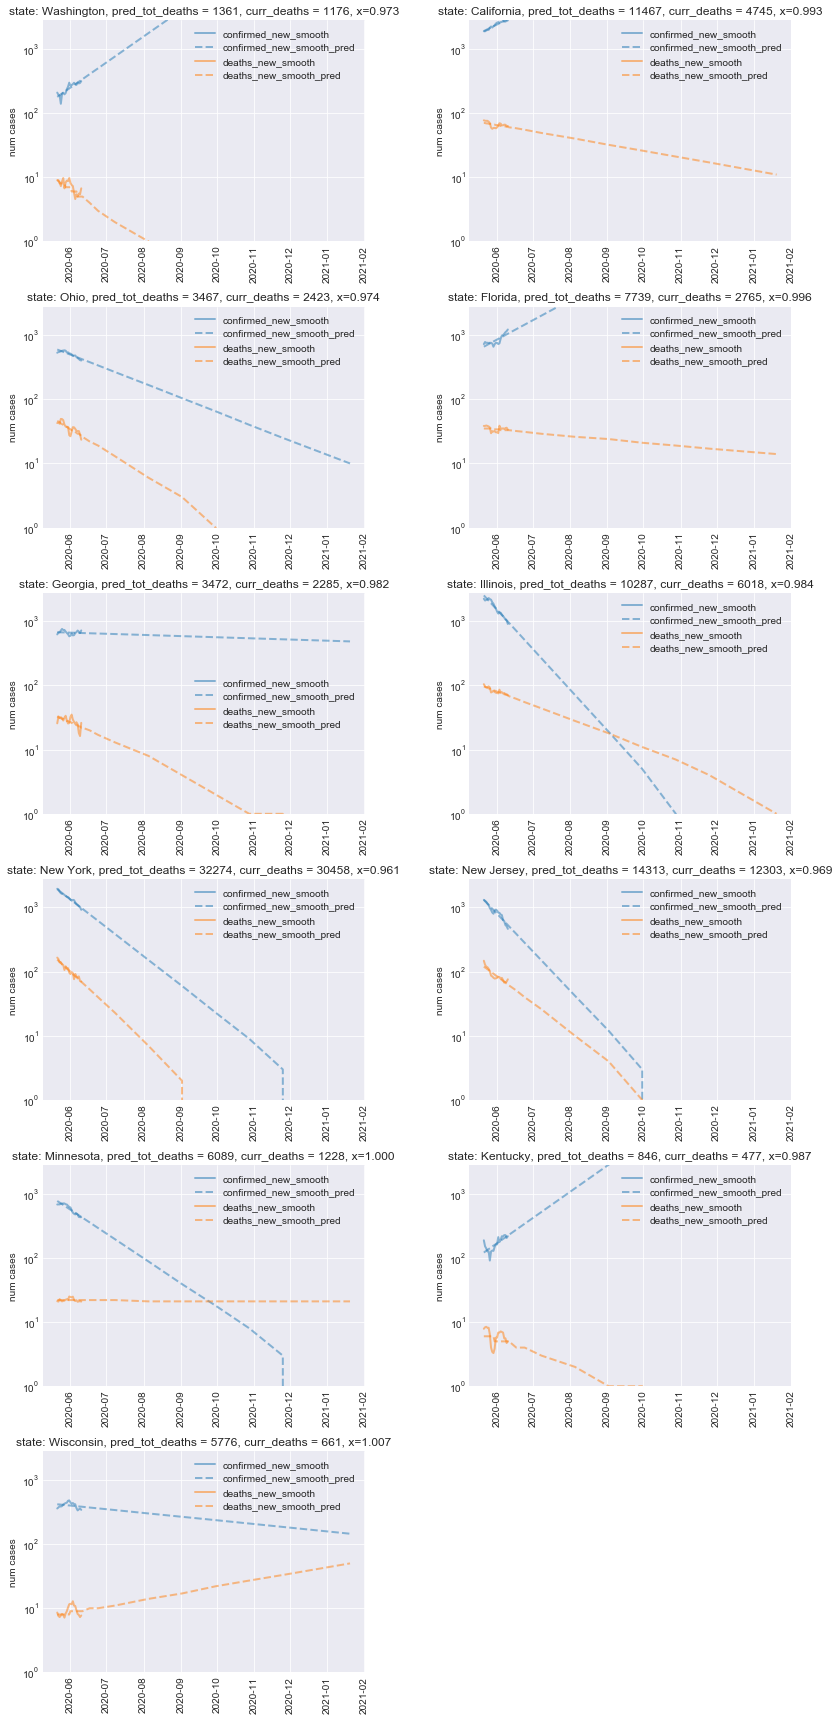

In [439]:
plot_forecasts_new(
    dfp_us_recent_1, 
    col_locale='state', 
    top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin'],
    cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
    cols_deaths='deaths_new_smooth',
)

In [440]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-06-10_n_days_training=21.csv


### Plot trends

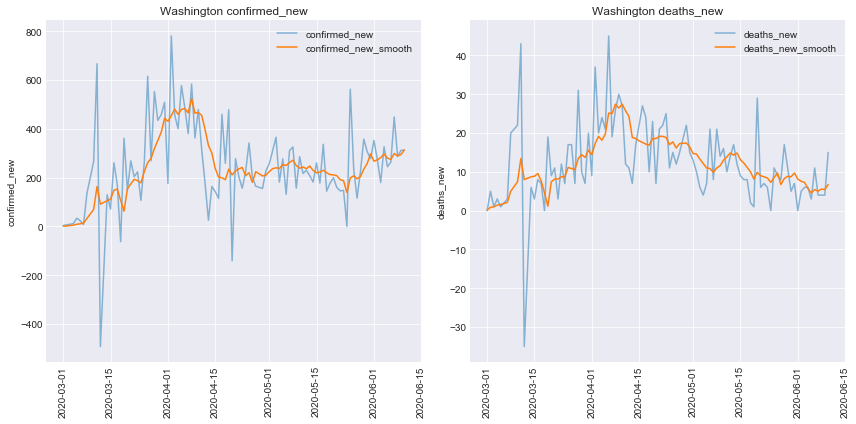

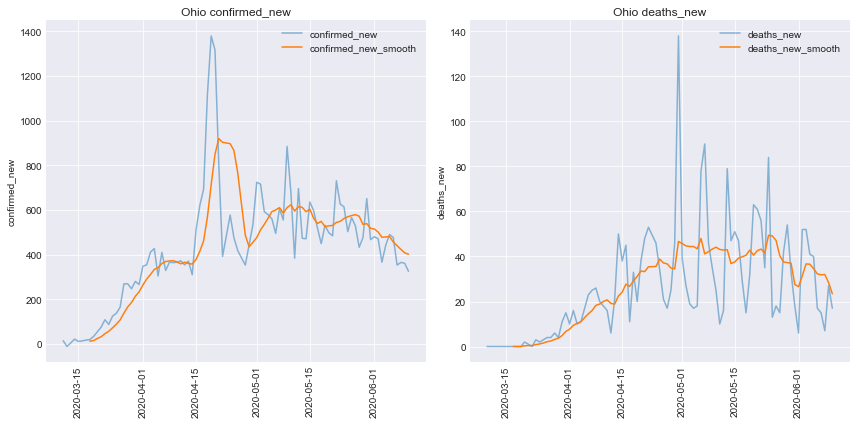

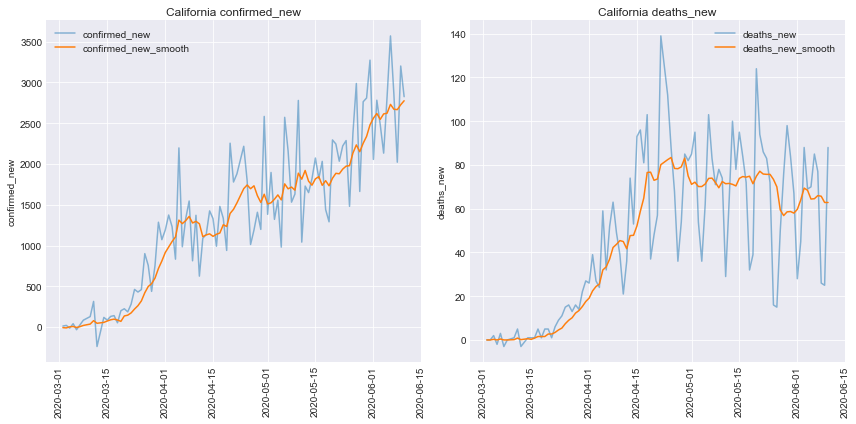

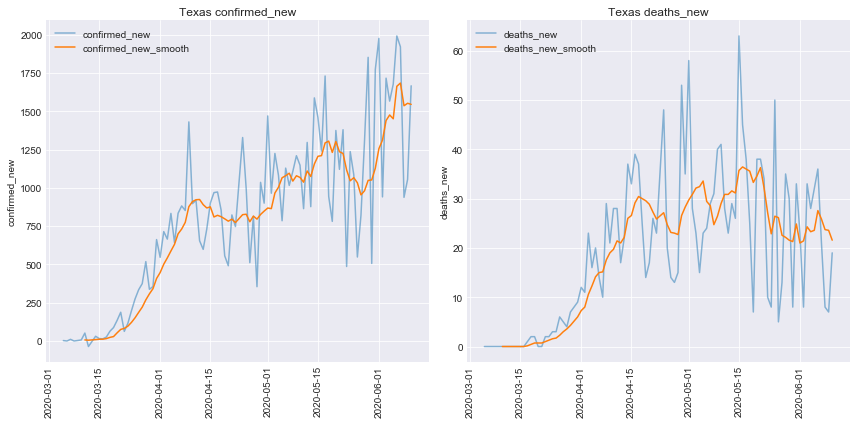

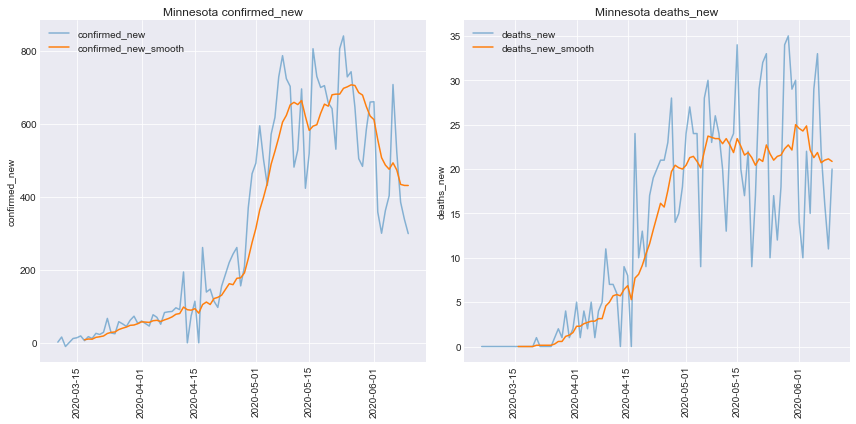

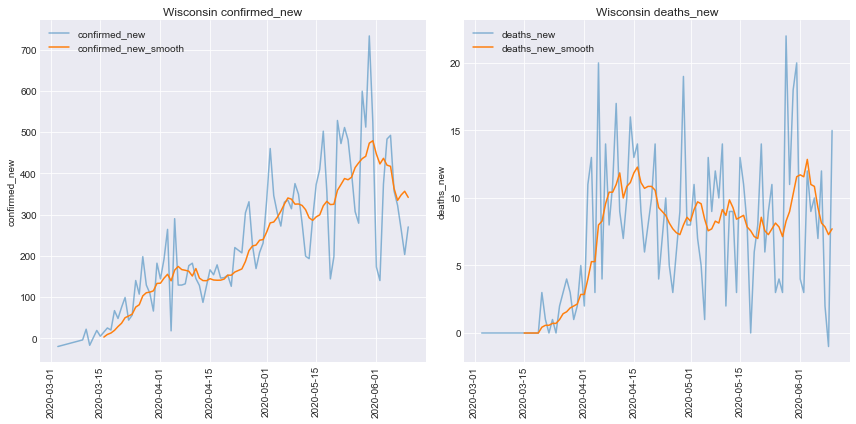

In [442]:
def plot_smoothed_trend(dfp_us_g, states, cols_plot=['confirmed_new'], dt_start=datetime.datetime(2020,3,1)):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            i += 1
        plt.tight_layout()
        plt.show()
    return None

plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [443]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                   Arkansas              0.030856                 0.045688
1                  Tennessee              0.028031                 0.028413
2                     Kansas              0.021165                -0.021750
3             South Carolina              0.008545                 0.043860
4                  Wisconsin              0.007385                -0.004316
5                    Arizona              0.005840                 0.065793
6               North Dakota              0.005396                -0.045719
7                    Alabama              0.005356                 0.001882
8             North Carolina              0.004990                 0.029861
9                      Maine              0.003687                -0.021324
10  Northern Mariana Islands              0.002648                 0.000000
11                    Oregon              0.002002                 0.030283
12            Virgin Islands              0.000000                 0.000000
13                   Vermont              0.000000                 0.085658
14                 Recovered              0.000000                 0.000000
15                    Alaska              0.000000                 0.125157
16                   Montana              0.000000                 0.072186
17            Grand Princess              0.000000                 0.000000
18                     Idaho              0.000000                 0.030583
19          Diamond Princess              0.000000                 0.000000
20                      Guam              0.000000                -0.007517
21                    Hawaii              0.000000                 0.041471
22                   Wyoming              0.000000                -0.038250
23              South Dakota             -0.000035                -0.007879
24                 Minnesota             -0.000123                -0.028058
25               Puerto Rico             -0.000326                 0.049837
26             West Virginia             -0.002097                -0.028829
27                   Florida             -0.003819                 0.023488
28             New Hampshire             -0.004190                -0.015810
29                California             -0.007327                 0.021490
30               Mississippi             -0.007923                 0.004071
31                  Michigan             -0.008716                 0.003395
32                     Texas             -0.010461                 0.023852
33                  Kentucky             -0.012782                 0.030713
34                New Mexico             -0.013004                 0.011888
35                  Maryland             -0.015950                -0.019872
36                  Illinois             -0.015952                -0.045897
37                   Georgia             -0.018231                -0.001346
38              Rhode Island             -0.018612                -0.050178
39                  Delaware             -0.019620                -0.060907
40                 Louisiana             -0.019879                -0.000756
41                      Iowa             -0.021879                -0.008629
42             Massachusetts             -0.022372                -0.022785
43                  Missouri             -0.022998                 0.019174
44                   Indiana             -0.023281                -0.015443
45                  Oklahoma             -0.024450                -0.006610
46                      Ohio             -0.025798                -0.016593
47                      Utah             -0.025859                 0.045405
48                  Nebraska             -0.025981                -0.014194
49                Washington             -0.026978                 0.030515
50              Pennsylvania             -0.027863                -0.028090
51                    Nevada             -0.030643                 0.01

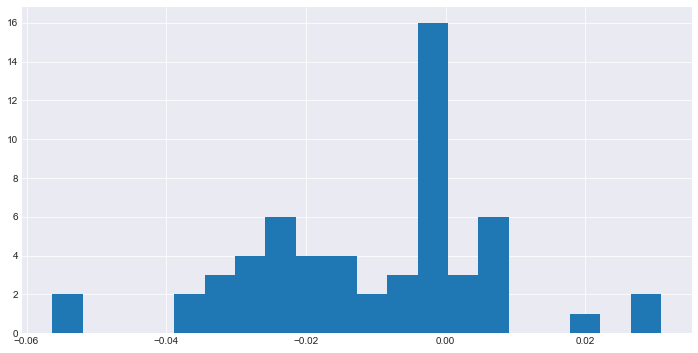

In [444]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

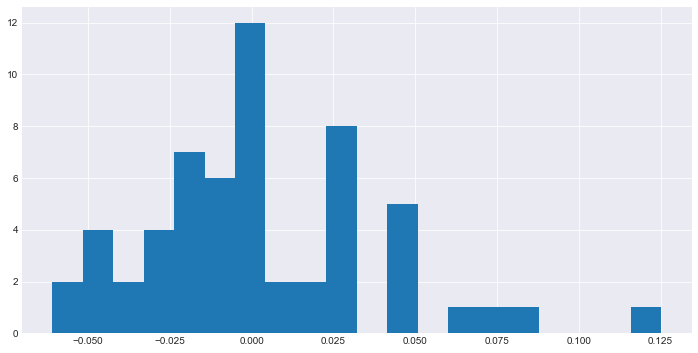

In [445]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [446]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0        Arkansas              0.030856                 0.045688
1       Tennessee              0.028031                 0.028413
2          Kansas              0.021165                -0.021750
3  South Carolina              0.008545                 0.043860
4       Wisconsin              0.007385                -0.004316
5         Arizona              0.005840                 0.065793
6    North Dakota              0.005396                -0.045719
7         Alabama              0.005356                 0.001882
8  North Carolina              0.004990                 0.029861
9           Maine              0.003687                -0.021324

### Which states are increasing in new deaths <u>least</u> quickly?

In [447]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48              Nebraska             -0.025981                -0.014194
49            Washington             -0.026978                 0.030515
50          Pennsylvania             -0.027863                -0.028090
51                Nevada             -0.030643                 0.010349
52            New Jersey             -0.031320                -0.044141
53              Virginia             -0.032898                -0.003477
54              New York             -0.038550                -0.032780
55              Colorado             -0.038603                -0.014301
56  District of Columbia             -0.052072                -0.035049
57           Connecticut             -0.056304                -0.051759

### Is there a day-of-the-week effect on new deaths?

In [448]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [449]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [450]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -1.666667        -0.275000    5.000000   
379  Washington    1    -0.333333        -0.080556    6.000000   
380  Washington    2     3.333333         0.666667    9.666667   
381  Washington    3     2.333333         0.365079    9.666667   
382  Washington    4    -0.333333        -0.050265    7.000000   
383  Washington    5     0.333333         0.099206    7.333333   
384  Washington    6    -3.000000        -0.400000    3.666667   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378                6.666667       148.000000             0.712206  
379                6.333333        14.000000             0.064563  
380                6.333333       -65.666667            -0.273837  
381                7.333333        13.000000             0.036585  
382                7.333333        18.666667             0.078513  
383                7.000000         1.333333            -0.001442  
384                6.666667        -3.333333            -0.116522

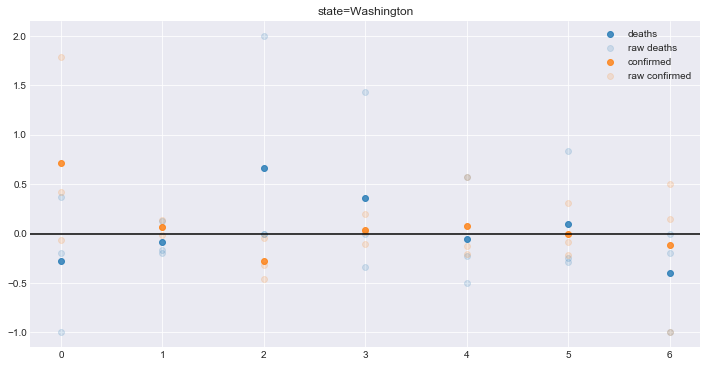

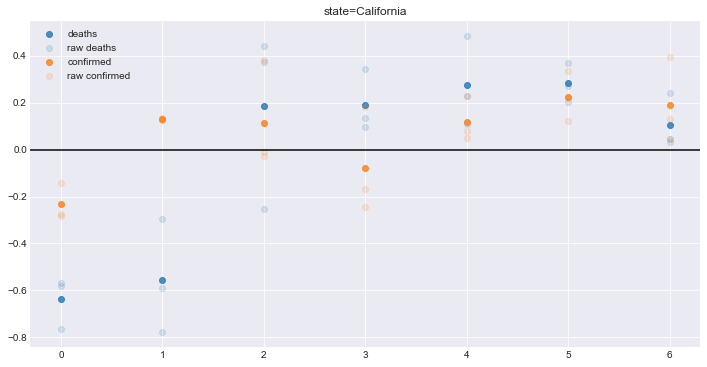

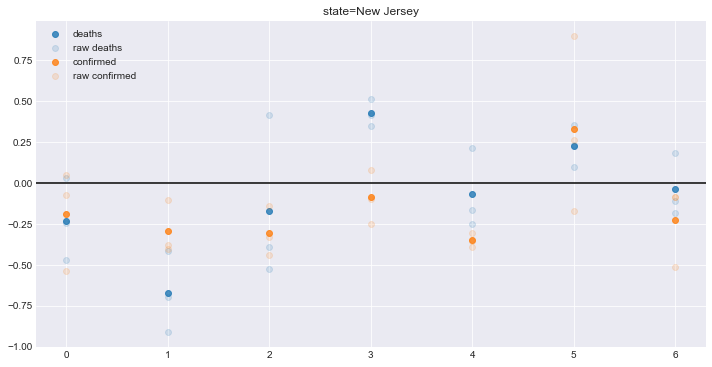

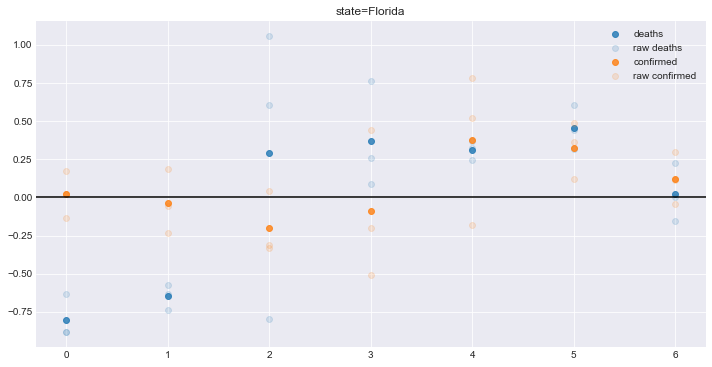

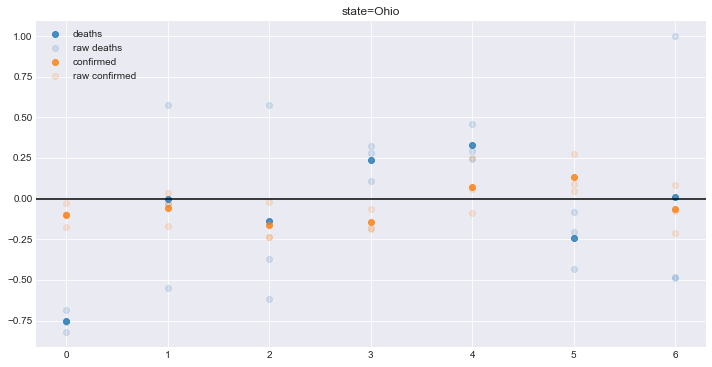

In [451]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()